# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](Need to update this).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import seaborn as sns

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df shape , head to get an idea of what the data 
# looks like
print("user-item df shape = ",df.shape)
print("user-item df w/o duplicates shape = ",df.drop_duplicates().shape)
print("There are repeated interactions.")
## Check for duplicates
df.head()



user-item df shape =  (45993, 3)
user-item df w/o duplicates shape =  (33682, 3)
There are repeated interactions.


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data,
# Check duplicates
print("articles-community df_content shape = ",df_content.shape)
print("articles-community df_content w/o duplicates shape = ", df_content.drop_duplicates().shape)
print("No duplicates here.")
df_content.head()


articles-community df_content shape =  (1056, 5)
articles-community df_content w/o duplicates shape =  (1056, 5)
No duplicates here.


,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### Perform Further Cleanup


In [3]:
## df_content.doc_status only contains 'Live', no useful info, so drop
## Ensure df.email is string stype

print("Unique df_content.doc_status values = ",np.unique(df_content.doc_status))
df_content.drop(['doc_status'],axis=1,inplace=True)
df.email      = df.email.astype(str).copy()

Unique df_content.doc_status values =  ['Live']


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

Number of total article interactions in dataset =  45993
Number of unique user - article pairs =  33682
count    5149.000000
mean        6.541464
std         9.990112
min         1.000000
25%         1.000000
50%         3.000000
75%         7.000000
max       135.000000
Name: email, dtype: float64


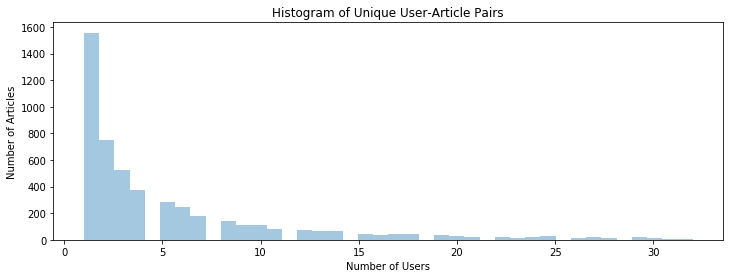

In [4]:
### Make a histogram of user interaction. 
### The question is looking for 'how many articles',so we count multiple
### interactions with an article by a single user only once.

df_u = df[['article_id','email']].drop_duplicates()
print("Number of total article interactions in dataset = ",df.shape[0])
print("Number of unique user - article pairs = ",df_u.shape[0])
## shows that some users have interacted with the same article multiple times

## Number of :unique: user-article interactions  
user_article_cnt = df_u.email.value_counts().sort_values()

## Describe and plot here
print(user_article_cnt.describe())
plt.figure(figsize=(12, 4))
ax = sns.distplot(user_article_cnt[0:5000], kde = False, bins = 40)
ax.set_xlabel("Number of Users")
ax.set_ylabel("Number of Articles")
ax.set_title("Histogram of Unique User-Article Pairs")

User statistics --------------------------------
count    5149.000000
mean        8.932414
std        16.801011
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: email, dtype: float64


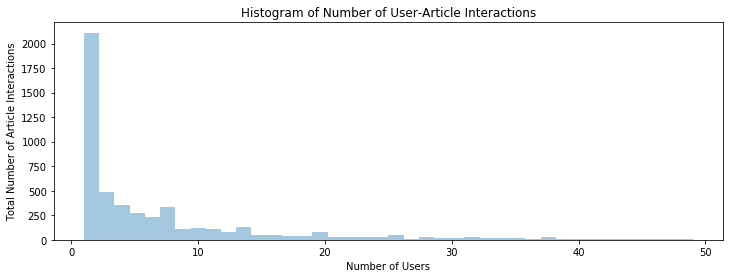

In [5]:
### The second statement above is a question about the number of times each user interacts
### with an article (user statistics). For this question provide a description based on the
### original df. 
user_article_cnt = df.email.value_counts().sort_values()

## Describe and plot here
print("User statistics --------------------------------")
print(user_article_cnt.describe())
plt.figure(figsize=(12, 4))
ax = sns.distplot(user_article_cnt[0:5000], kde = False, bins = 40)
ax.set_xlabel("Number of Users")
ax.set_ylabel("Total Number of Article Interactions")
ax.set_title("Histogram of Number of User-Article Interactions")

In [6]:
# Fill in the median and maximum number of user_article interactions below
median_val = user_article_cnt.median() # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = user_article_cnt.max() # The maximum number of user-article interactions by any 1 user is ______.

print("50% of individuals interact with ", median_val, "number of articles or fewer.")
print("The maximum number of user-article interactions by any 1 user is ", max_views_by_user)

50% of individuals interact with  3.0 number of articles or fewer.
The maximum number of user-article interactions by any 1 user is  364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [7]:
# Find and explore duplicate articles
# Show duplicate articles from df_content
a  = df_content.article_id.value_counts()
a  = a[a.values > 1]
l  = list(a.keys())
print("Duplicate article_ids from df_content ---------------------")
df_content[df_content.article_id.map(lambda x: x in l)].sort_values('article_id')

Duplicate article_ids from df_content ---------------------


,doc_body,doc_description,doc_full_name,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,577


In [8]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset = ['article_id'],keep = 'first',inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values)<br> 
**d.** The number of user-article interactions in the dataset.

In [9]:
## The following code shows that there are 17 email ids that are different
## from the rest. These are 'nan's -- so we will remove
## We'll keep two dataframes df contains the nans, dfw does not
print("Length of email id vs number found")
tns = df.email.map(lambda x: len(x))
print(tns.value_counts())

dfw = df.copy() ## dfw will not include nans 
dfw = dfw[dfw.email != 'nan']
dfw.shape

Length of email id vs number found
40    45976
3        17
Name: email, dtype: int64


(45976, 3)

In [10]:
unique_articles = len(np.unique(dfw.article_id))# The number of unique articles that have at least one interaction
total_articles  = len(df_content.article_id)# The number of unique articles on the IBM platform
#unique_users    = len(np.unique(dfw.email.dropna().str.strip()))    # The number of unique users
unique_users    = dfw.email.dropna().nunique()
user_article_interactions =  df.shape[0]# The number of user-article interactions

In [11]:
print("The number of unique articles that have at least one interaction = ",unique_articles)
print("The number of unique articles on the IBM platform = ",total_articles)
print("The number of unique users = ",unique_users)
print("The number of user-article interactions = ",user_article_interactions)

The number of unique articles that have at least one interaction =  714
The number of unique articles on the IBM platform =  1051
The number of unique users =  5148
The number of user-article interactions =  45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was find using other information that all of these null values likely belonged to a single user.

In [12]:
df1 = df.article_id.value_counts().sort_values(ascending = False)

most_viewed_article_id = str(df1.keys()[0]) 
max_views = df1.values[0]# The most viewed article in the dataset was viewed how many times?
print("The most viewed article in the dataset = ",most_viewed_article_id)
print("The most viewed article was viewed ",max_views, " times.")

The most viewed article in the dataset =  1429.0
The most viewed article was viewed  937  times.


In [13]:
## No need to change the code here - this will be helpful for later parts of the notebook
## Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [14]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [15]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    nmax = len(df.title.value_counts().keys())
    n = min(n,nmax)
    if(n < 1):
        n=1
    top_articles = list(df.title.value_counts().sort_values(ascending=False).keys()[:n])
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids
    
    '''

    nmax = len(df.article_id.value_counts().keys())
    n = min(n,nmax)
    if(n < 1):
        n=1
    top_articles = list(df.article_id.value_counts().sort_values(ascending=False).keys()[:n])
    
    return top_articles # Return the top article ids

In [16]:
dfTop10 = pd.DataFrame({'article_id':get_top_article_ids(10),'title':get_top_articles(10)})
print('Top 10 articles ids ------------------------------')
dfTop10.head(10)

Top 10 articles ids ------------------------------


,article_id,title
0,1429.0,use deep learning for image classification
1,1330.0,insights from new york car accident reports
2,1431.0,visualize car data with brunel
3,1427.0,"use xgboost, scikit-learn & ibm watson machine..."
4,1364.0,predicting churn with the spss random tree alg...
5,1314.0,healthcare python streaming application demo
6,1293.0,finding optimal locations of new store using d...
7,1170.0,"apache spark lab, part 1: basic concepts"
8,1162.0,analyze energy consumption in buildings
9,1304.0,gosales transactions for logistic regression m...


In [17]:
# Test your function by returning the top 5, 10, and 20 articles
top_5  = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [18]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    df1 = df.drop_duplicates().copy()
    # Group and unstack
    mat = df1.groupby(['user_id', 'article_id'])['title'].max().unstack()
    # Convert NaNs (no interaction) to False, existing interaction to True
    mat = mat.notna().astype(int)
    # True/False --> 1/0
    mat.index = mat.index.astype(int)
    
    return mat # return the user_item matrix 
    
user_item = create_user_item_matrix(df)


In [19]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


In [20]:
## Save to pickle file
user_item.to_pickle("user_item_matrix.p")

`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [21]:
def find_similar_users(user_id, user_item=user_item,ret_series=False):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    most_similar_users - (list), if ret_series =False, an ordered list where the closest users (largest dot product users)
                    are listed first
    most_similar_users - (pd.Series) if ret_series =True, an ordered pd.Series where the closest users (largest dot product users)
                    are listed first
    
    Note my change:   ret_series =True then return pandas Series with user_ids 
                      similarity measure, instead of list 
                    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    # compute as overlap (dot_product) over vectors
    a = np.dot(user_item ,user_item[user_item.index==user_id].transpose())
    b = a[:,0]
    p = pd.Series(data = b,index = user_item.index)
    
    # remove own user_id
    p.drop(labels = [user_id],inplace=True)
    p.sort_values(ascending=False,inplace=True)
    
    # Option to return the pandas series, not just keys
    most_similar_users  = p 
    if(ret_series==False):
        most_similar_users = list(p.keys())
    
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [22]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 3697]
The 5 most similar users to user 3933 are: [1, 3782, 23, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


In [23]:
## Ensure df.article_id is string type
## 
df.article_id = df.article_id.astype(str).copy() 

`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [24]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    dfu = df[['article_id','title']].drop_duplicates().copy()
    
    ## Slow loop to ensure order, there is a better way to do this, ensure proper order
    article_names = []
    dfu = dfu[dfu.article_id.isin(article_ids)]

    for article_id in article_ids:
        dfus = dfu[dfu.article_id==article_id]
        if(dfus.shape[0] > 0): 
            #print(dfus.loc[0,1])
            article_names.append(dfus.iloc[0,1])
        else:
            article_names.append("")
    return article_names # Return the article names associated with list of article ids



## Convenient modification here
## seen = True   return articles that user_id has seen
##      = False  return articles that user_id has NOT seen
def get_user_articles(user_id, seen = True, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    seen    - (True,False): return articles user (has,has not) seen 
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    ### Alternate approach
    ## a = a.transpose().to_numpy()
    ## b = a[:,0]
    ## p = pd.Series(data=a,index=cols)
    ##list(p.keys()[np.where(p == 1)])
      
    # Your code here
    s = int(seen)
    article_ids = []
    cols = list(user_item.columns)
    for col in cols:
        if(user_item.loc[user_id,col] == s):
            article_ids.append(str(col))
            
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    
    ## Get articles user has read and has not read
    user_read_article_ids, names   = get_user_articles(user_id,True)
    user_unread_article_ids, names = get_user_articles(user_id,False)
    ## Get total num articles
    N = len(user_read_article_ids + user_unread_article_ids)
    
    m = min(m,N)
    ## Return most similar users
    rec_article_ids = []
    sim_user_ids = find_similar_users(user_id)
    #print(sim_user_ids[0:2])
    
    if(m > 0):
        for sim_user_id in sim_user_ids:
            sim_user_article_ids, sim_user_article_names = get_user_articles(sim_user_id,True)
            article_ids = list(set(user_unread_article_ids) & set(sim_user_article_ids))


            if(len(article_ids) > 0):
                rec_article_ids += article_ids
                # Update user_unread_article_ids, remove article_ids
                user_unread_article_ids =list(set(user_unread_article_ids) ^ set(article_ids))
                if(len(rec_article_ids) >= m):
                    #print("at return")
                    return rec_article_ids[0:m]
            
    
    ## This return should never be reached
    return [] # return your recommendations for this user_id    

In [25]:
# Test your functions here - No need to change this code - just run this cell

assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [26]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''

    ## For a given user_id get similar 
    similar_s    = find_similar_users(user_id, user_item=user_item,ret_series=True)
    interact_s   = df.user_id.value_counts().copy()
    neighbors_df = similar_s.to_frame().join(interact_s)
    neighbors_df.columns  = ['similarity','n_interact']
    neighbors_df.reset_index(inplace=True)
    neighbors_df.sort_values(by = ['similarity','n_interact'], ascending = [False,False],inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def sorted_articles(df=df):
    '''
    Input: user-article interaction dataframe, df
    Output: dataframe containing article_id,number of interactions with article
            sorted descending on the number of interactions
    '''
    
    sorted_articles_df         = df.article_id.value_counts().to_frame().reset_index().copy()
    sorted_articles_df.columns = ['article_id','n_interact']
    sorted_articles_df.sort_values('n_interact',ascending=False,inplace=True)
    return sorted_articles_df


def user_user_recs_part2(user_id, m=10, df=df):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    df - user-article interaction dataframe
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    * To be clear the sorting order is 
        1. User similarity
        2. Users with the most interactions
        3. Articles with the most total interactions
    '''
    
    ## Get articles user has read and has not read
    user_read_article_ids, names   = get_user_articles(user_id,True)
    user_unread_article_ids, names = get_user_articles(user_id,False)
    ## Get total num articles
    N = len(user_read_article_ids + user_unread_article_ids)
    
    m = min(m,N)
    ## Get most similar users
    rec_article_ids = []
    sim_user_ids = find_similar_users(user_id)
    
    
    ## Get dataframe with article_ids sorted according to num interactions
    sorted_articles_df = sorted_articles(df)
    
    rec_article_ids = [];ret_article_names = [];
    if(m > 0):
        ## Get closest users
        neighbors_df = get_top_sorted_users(user_id)
        sim_user_ids = list(neighbors_df.user_id)
        for sim_user_id in sim_user_ids:
            
            ## Get articles from this similar user, users here are sorted according
            ## to most user interactions. Sorting order is  similarity, then user_num_interactions
            sim_user_article_ids, sim_user_article_names = get_user_articles(sim_user_id)
            
            ## Get articles from the similar user that are unread by user_id
            article_ids = list(set(user_unread_article_ids) & set(sim_user_article_ids))
            
            ## Sort these articles according to number of :article: interactions
            dfs = sorted_articles_df[sorted_articles_df.article_id.isin(article_ids)]
            article_ids = list(dfs.sort_values(by = 'n_interact',ascending = False).article_id)


            if(len(article_ids) > 0):

                # Add found articles to the list
                rec_article_ids += article_ids  
                # Update unread articles
                user_unread_article_ids = list(set(user_unread_article_ids) ^ set(article_ids))

                ## Check if we found enough
                if(len(rec_article_ids) >= m):
                    rec_article_ids = rec_article_ids[0:m]
                    break;

  
    rec_article_names = get_article_names(rec_article_ids)
    return rec_article_ids, rec_article_names

In [27]:
### Quick test
rec_ids, rec_names = user_user_recs_part2(20,10)
print(rec_ids)

['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0']


In [28]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0']

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [29]:
### Tests with a dictionary of results
user1_most_sim =  find_similar_users(1)[0]    # Find the user that is most similar to user 1 
user131_10th_sim = find_similar_users(131)[9] # Find the 10th most similar user to user 131

In [30]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**


*If the user is brand new, and we do not have any relevant information for that user
(for use in content recommendations for example), then the best we can do is to 
recommend the most popular articles.*

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [31]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'? 
# As a new user, they have no observed articles, so all we can do is provide the most
# popular articles 

# For a new user, return the top 10 most popular articles
sorted_articles_df = sorted_articles()
#sorted_articles_df.head(13)
new_user_recs = sorted_articles_df.article_id[0:10] # Your recommendations here

In [32]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [33]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [34]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [35]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [36]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perfrom SVD, and explain why this is different than in the lesson.

In [37]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

**Provide your response here.**

In the lesson, we were dealing with breaking down a user-movie rating matrix (**R**) into components that express the user-latent_feature (**S**) and movie-latent_feature (**V**) relationships, along with a weighting (**D**) for the significance of each feature. The values in the matrix are numerical (ratings). When all values are present, the usual SVD algorithm can be applied, but not when even one value is missing. 

We saw that in the missing values case we could create a similar breakdown, by writing down the equations **R = SVD**, for only the existing values in R and calculating SVD via the generalized gradient method. This is sort of like the optimization problem *min*(**R - SVD** ). 

Here we are dealing with an interaction matrix, so the values are boolean (0 or 1). No values
will be missing of course, either a user has interacted with an article or not. Therefore,
the conventional decomposition approach is applicable.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

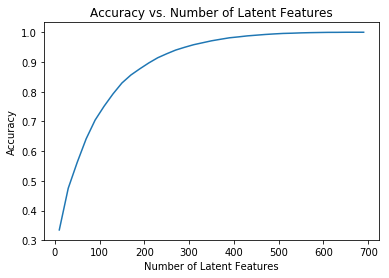

In [38]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [39]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test  = create_user_item_matrix(df_test)
    test_idx        =  list(np.unique(df_test.user_id))
    test_arts       =  list(np.unique(df_test.article_id))
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)
print(user_item_train.shape)
print(user_item_test.shape)
print(len(test_idx))
print(len(test_arts))

(4487, 714)
(682, 574)
682
574


In [40]:
## Determine users common to both sets
users_common = list(set(user_item_test.index) & set(user_item_train.index))
## Determine articles common to both sets
arts_common  = list(set(user_item_test.columns) & set(user_item_train.columns))

In [41]:
print("\nHow many users can we make predictions for in the test set? ", len(users_common))  
print("\nHow many users are we not able to make predictions for")
print("because of the cold start problem? ", user_item_test.shape[0] - len(users_common))
print("\nHow many articles can we make predictions for in the test set? ", len(arts_common))  
print("\nHow many articles are we not able to make predictions for because of the cold start problem? ",
      user_item_test.shape[1] - len(arts_common))



How many users can we make predictions for in the test set?  20

How many users are we not able to make predictions for
because of the cold start problem?  662

How many articles can we make predictions for in the test set?  574

How many articles are we not able to make predictions for because of the cold start problem?  0


In [42]:
## Subset test set according to user_ids
user_item_test   = user_item_test[user_item_test.index.isin(users_common)]


## Get subsetting bool lists for subsetting estimate of user_item_train matrix
col_sub = list(user_item_train.columns.isin(arts_common))
row_sub = list(user_item_train.index.isin(users_common))

## Demonstrate alignment of indices to demonstrate that our usage of these lists
## is valid
print("Index alignment test ---- ")
user_item_train_sub = user_item_train.loc[row_sub,col_sub]
print(list(user_item_test.index)   == list(user_item_train_sub.index))
print(list(user_item_test.columns) == list(user_item_train_sub.columns))

Index alignment test ---- 
True
True


In [43]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find **U**, **S**, and **V** transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [44]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train,full_matrices=False)

print(u_train.shape,len(s_train),vt_train.shape)

(4487, 714) 714 (714, 714)


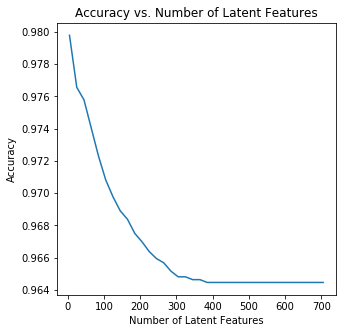

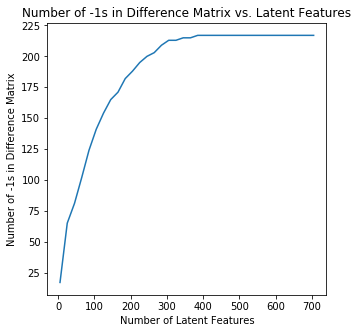

In [45]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
#
# We iterate over latent features exactly as before just calculating the error
# for the test subset of users and articles 
#
# Note I used u_test_size in place of df.shape[0], just felt that
# this was more appropriate
#
u_test_size = user_item_test.shape[0]*user_item_test.shape[1]
num_latent_feats = np.arange(5,700+10,20)
sum_errs = []
neg_ones = []
for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    user_item_est_sub = user_item_est[row_sub,:]
    user_item_est_sub = user_item_est_sub[:,col_sub]
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test, user_item_est_sub)
    
    neg_ones.append(len(np.where(diffs==-1)[0]))
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
plt.figure(figsize=(5,5))
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/u_test_size);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

plt.figure(figsize=(5,5))
plt.plot(num_latent_feats, neg_ones)
plt.title("Number of -1s in Difference Matrix vs. Latent Features")
plt.ylabel('Number of -1s in Difference Matrix')
plt.xlabel('Number of Latent Features')

In [46]:
### Show accuracy from direct_comparison

user_item_est = user_item_train.to_numpy()
user_item_est = user_item_est[row_sub,:]
user_item_est = user_item_est[:,col_sub]
diffs = np.subtract(user_item_test, user_item_est)
err = np.sum(np.sum(np.abs(diffs)))
print("Asymptote Accuracy = ", 1- err/u_test_size)


Asymptote Accuracy =  0.9644599303135889


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 


*What I have done here is to simply show the change in error between increasingly
 better approximations to user_item_train (via the number eigen-modes included) and 
 user_item_test for the 20 in common users.*
 
*It is a bit serendipitous that the result is slightly better with fewer eigenvalues.
 For this particular case, more eigenvectors contributing creates more **1**s in the relevant
 part of the estimate matrix that do not correspond to **1**s in the test matrix, 
 thereby  increasing the error. This is demonstrated in the second plot above, which shows
 the increase in the number of **-1s** in the difference matrix as the number
 of latent features
 increases. The error asymptotes once the estimate matrix is essentially the same as the 
 original user_item_train matrix.*
 
 *Of course, we have the full user_item_train to begin with, so we can just compare it
 directly to user_item_test. It should be noticed that a careful train and test separation
 of the original data frame 'df', could possibly result in user_item_train = user_item_test
 for the in common users; for instance, if a unique set of all relevant user-article
 interactions exists in the train set, and all duplicate interactions are in the test set.*
 
 *To determine the quality of and compare our recommendation system approaches,
 I would look at the number of user-article interactions over time. One recommendation system would be used for one group and another for a control group. The statistical methods discussed in the A/B testing section of the lesson would be relevant here. Multiple approaches might be tested simultaneously applied using ANOVA (Analysis of Variance), but we would then want to rotate the methods across the user population, to ensure the results are not due to variations in the user population itself.*  

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [47]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0